In [ ]:
!pip install --upgrade gensim
!pip install torch
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from gensim.models import Word2Vec, KeyedVectors
import time

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [ ]:
import gensim.downloader
w2v = gensim.downloader.load('word2vec-google-news-300')

In [ ]:
# # Load the Google News Word2Vec model
# m = gensim.downloader.load('word2vec-google-news-300')

# # Specify the path where you want to save the model
# m_path = 'google_news_word2vec.model'

# # Save the model to the specified path
# m.save(m_path)

In [ ]:
# w2v = KeyedVectors.load('google_news_word2vec.model')

## Set Seed

In [ ]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Reading our csv

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.shape)
print(test.shape)

(5452, 3)
(500, 3)


## Dropping label-fine

In [ ]:
train = train.drop("label-fine", axis=1)
test = test.drop("label-fine", axis=1)

In [ ]:
train.head()

,label-coarse,text
0,0,How did serfdom develop in and then leave Russ...
1,1,What films featured the character Popeye Doyle ?
2,0,How can I find a list of celebrities ' real na...
3,1,What fowl grabs the spotlight after the Chines...
4,2,What is the full form of .com ?


In [ ]:
test.head()

,label-coarse,text
0,4,How far is it from Denver to Aspen ?
1,5,"What county is Modesto , California in ?"
2,3,Who was Galileo ?
3,0,What is an atom ?
4,4,When did Hawaii become a state ?


## Converting our labels into strings for easier processing

In [ ]:
train["label-coarse"] = train["label-coarse"].astype(str)
test["label-coarse"] = test["label-coarse"].astype(str)

## Obtaining our development set

In [ ]:
dev = train.sample(500, random_state=1)
dev = dev.reset_index(drop=True)  #reset index so that it starts from 0
dev

,label-coarse,text
0,3,Who is Count Cinzano ?
1,0,How do Ouija Boards work ?
2,4,At what age did Rossini stop writing opera ?
3,5,What New England state covers 5.9 square miles ?
4,5,What city has the world 's longest subway syst...
...,...,...
495,3,Who invented television ?
496,5,What country has been called The Queen of the ...
497,1,What did Benny Carter play ?
498,4,What is the estimated total U.S. whitetail dee...


#### Removing the subset from our train

In [ ]:
train = train.drop(index=list(dev.index))
train = train.reset_index(drop=True) #reset index so that it starts from 0

## Final shape of our 3 df

In [ ]:
print(f"Train shape:\t {train.shape}")
print(f"Dev shape:\t {dev.shape}")
print(f"Test shape:\t {test.shape}")

Train shape:	 (4952, 2)
Dev shape:	 (500, 2)
Test shape:	 (500, 2)


## Randomly selecting 4 course labels, and combining the 2 remaining as "OTHERS"
From the documentation, the labels are defined as:
- 'ABBR' (0): Abbreviation.
- 'ENTY' (1): Entity.
- 'DESC' (2): Description and abstract concept.
- 'HUM' (3): Human being.
- 'LOC' (4): Location.
- 'NUM' (5): Numeric value.

In [ ]:
labels = ["0","1","2","3","4","5"]

#get our random 2 labels that will be changed to OTHERS
np.random.seed(1)
twoLabels = np.random.choice(labels, size=2, replace = False)
twoLabels

array(['2', '1'], dtype='<U1')

In [ ]:
train = train.replace(to_replace=twoLabels, value="OTHERS")
test = test.replace(to_replace=twoLabels, value="OTHERS")
dev = dev.replace(to_replace=twoLabels, value="OTHERS")

In [ ]:
print(train["label-coarse"].nunique())
print(train["label-coarse"].unique())

5
['4' '3' '5' 'OTHERS' '0']


In [ ]:
print(test["label-coarse"].unique())

['4' '5' '3' '0' 'OTHERS']


---
The final 5 classes that we are using are:
- OTHERS
- 0
- 3
- 4
- 5
---

### Encoding the labels with LabelEncoder for the model to train

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train["label-coarse"] = label_encoder.fit_transform(train["label-coarse"].values)
test["label-coarse"] = label_encoder.transform(test["label-coarse"].values)
dev["label-coarse"] = label_encoder.transform(dev["label-coarse"].values)

## Further exploring the df

In [ ]:
train.head()

,label-coarse,text
0,2,How long does it take for Spider-Man 's web to...
1,1,Who was Randy Steven Craft 's lawyer ?
2,3,What was known as the Spice Island ?
3,1,Who was the first host of Person to Person ?
4,1,Name the Ranger who was always after Yogi Bear .


In [ ]:
test_sentence = train["text"][0]
print(test_sentence)
print(type(test_sentence))

How long does it take for Spider-Man 's web to evaporate ?
<class 'str'>


In [ ]:
sentence_list = test_sentence.split(" ")
sentence_list

['How',
 'long',
 'does',
 'it',
 'take',
 'for',
 'Spider-Man',
 "'s",
 'web',
 'to',
 'evaporate',
 '?']

- We have to figure out how would w2v handle words not in its vocab
- "?" is not in its vocab, but it can be easily handled by removing it from every sentence

## Aggregation method
- Taking representation of last word


## Preparing our data

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\SQ
[nltk_data]     XPS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#this function will help us to tokenize the text into individual tokens
def tokenizeText(df):

    #duplicating the df
    copy = df.copy(deep=True)
    copy = copy.reset_index(drop=True)

    copy["tokenized_text"] = copy["text"].apply(nltk.word_tokenize)
    return copy

## Tokenizing the tex of our train, dev, test df

---
This is what our current df looks like

In [ ]:
train.head()

,label-coarse,text
0,2,How long does it take for Spider-Man 's web to...
1,1,Who was Randy Steven Craft 's lawyer ?
2,3,What was known as the Spice Island ?
3,1,Who was the first host of Person to Person ?
4,1,Name the Ranger who was always after Yogi Bear .


---
This is what it looks like after aggregation

In [ ]:
train_tokenized = tokenizeText(train)
dev_tokenized = tokenizeText(dev)
test_tokenized = tokenizeText(test)

In [ ]:
train_tokenized.head()

,label-coarse,text,tokenized_text
0,2,How long does it take for Spider-Man 's web to...,"[How, long, does, it, take, for, Spider-Man, '..."
1,1,Who was Randy Steven Craft 's lawyer ?,"[Who, was, Randy, Steven, Craft, 's, lawyer, ?]"
2,3,What was known as the Spice Island ?,"[What, was, known, as, the, Spice, Island, ?]"
3,1,Who was the first host of Person to Person ?,"[Who, was, the, first, host, of, Person, to, P..."
4,1,Name the Ranger who was always after Yogi Bear .,"[Name, the, Ranger, who, was, always, after, Y..."


## Converting our list of tokenized text into its respective word embeddings using word2vec

- For those words without a valid embedding from w2v pretrained model, we will be tackling them by using a 0 vector of shape (300, )

In [ ]:
zero_vector = np.zeros(300)
zero_vector.shape

(300,)

In [ ]:
def embed(df):
    #duplicating the df
    copy = df.copy(deep=True)
    copy = copy.reset_index(drop=True)

    #this list will store all the lists of word embeddings of all sentences
    embedded_col = []

    #for each row
    for i in range(len(df)):

        #this list will store all word embeddings in 1 sentence
        embedded_text_list = []

        #for each word in the tokenized_text list
        for j in df["tokenized_text"][i]:
            try:
                #embed the word into its respective vector
                v = w2v[j]

                #append the vector to a list
                embedded_text_list.append(v)

            #we encounter a OOV word
            except:
                embedded_text_list.append(zero_vector)

        embedded_col.append(embedded_text_list)


    copy["embedded_text"] = embedded_col
    return copy

In [ ]:
train_embedded = embed(train_tokenized)
dev_embedded = embed(dev_tokenized)
test_embedded = embed(test_tokenized)

train_embedded.head()

,label-coarse,text,tokenized_text,embedded_text
0,2,How long does it take for Spider-Man 's web to...,"[How, long, does, it, take, for, Spider-Man, '...","[[0.16015625, 0.21679688, 0.05493164, 0.207031..."
1,1,Who was Randy Steven Craft 's lawyer ?,"[Who, was, Randy, Steven, Craft, 's, lawyer, ?]","[[0.052246094, 0.055664062, 0.20898438, 0.3144..."
2,3,What was known as the Spice Island ?,"[What, was, known, as, the, Spice, Island, ?]","[[-0.023071289, 0.15332031, 0.15234375, 0.0505..."
3,1,Who was the first host of Person to Person ?,"[Who, was, the, first, host, of, Person, to, P...","[[0.052246094, 0.055664062, 0.20898438, 0.3144..."
4,1,Name the Ranger who was always after Yogi Bear .,"[Name, the, Ranger, who, was, always, after, Y...","[[0.03930664, -0.15527344, 0.052490234, -0.171..."


#### Ensuring dimensions are correct

In [ ]:
print(f"length of first tokenzied text: {len(train_embedded['tokenized_text'][0])}")

print(f"length of first embedded text: {len(train_embedded['embedded_text'][0])}")

print(f"shape of first embedded text: {np.shape(train_embedded['embedded_text'][0])}")

length of first tokenzied text: 12
length of first embedded text: 12
shape of first embedded text: (12, 300)


---

## Padding Sentences with 0-vectors such that they are the same size as the max words in all sentences

### Finding the longest sentence in the dfs

1) Train

In [ ]:
train_text_length = []

for i in range(len(train_tokenized["tokenized_text"])):
    train_text_length.append(len(train_tokenized["tokenized_text"][i]))


print(f"Total sentences: {len(train_text_length)}")

maxTrainWords = max(train_text_length)
print(f"Max words in sentences: {maxTrainWords}")

Total sentences: 4952
Max words in sentences: 37


2) Dev

In [ ]:
dev_text_length = []

for i in range(len(dev_tokenized["tokenized_text"])):
    dev_text_length.append(len(dev_tokenized["tokenized_text"][i]))

print(f"Total sentences: {len(dev_text_length)}")

maxDevWords = max(dev_text_length)
print(f"Max words in sentences: {maxDevWords}")

Total sentences: 500
Max words in sentences: 32


3) Test

In [ ]:
test_text_length = []

for i in range(len(test_tokenized["tokenized_text"])):
    test_text_length.append(len(test_tokenized["tokenized_text"][i]))

print(f"Total sentences: {len(test_text_length)}")

maxTestWords = max(test_text_length)
print(f"Max words in sentences: {maxTestWords}")

Total sentences: 500
Max words in sentences: 17


### Start padding

We now pad all sentences to the maximum number of words in any sentence in the test, dev and train dataframes combined

In [ ]:
def padEmbedding(df, maxWords):
    #duplicating the df
    copy = df.copy(deep=True)
    copy = copy.reset_index(drop=True)

    padded_embedding = []

    for i in range(len(df)):
        embedding = copy["embedded_text"][i]
        numWords = len(embedding)
        numToPad = maxWords - numWords

        for i in range(numToPad):
            embedding.append(zero_vector)

        padded_embedding.append(embedding)

    copy["padded_embedding"] = padded_embedding

    return copy

In [ ]:
train_padded = padEmbedding(train_embedded, maxTrainWords)
dev_padded = padEmbedding(dev_embedded, maxTrainWords)
test_padded = padEmbedding(test_embedded, maxTrainWords)

#### Ensuring dimensions are correct

In [ ]:
print(maxTrainWords)
np.shape(train_padded["padded_embedding"][0])

37


(37, 300)

Saving dataset

---
## Splitting our data into X and y components

In [ ]:
X_train = train_padded["padded_embedding"]
y_train = train_padded["label-coarse"]

X_dev = dev_padded["padded_embedding"]
y_dev = dev_padded["label-coarse"]

X_test = test_padded["padded_embedding"]
y_test = test_padded["label-coarse"]

In [ ]:
X_train.head()

0    [[0.16015625, 0.21679688, 0.05493164, 0.207031...
1    [[0.052246094, 0.055664062, 0.20898438, 0.3144...
2    [[-0.023071289, 0.15332031, 0.15234375, 0.0505...
3    [[0.052246094, 0.055664062, 0.20898438, 0.3144...
4    [[0.03930664, -0.15527344, 0.052490234, -0.171...
Name: padded_embedding, dtype: object

In [ ]:
y_train.head()

0    2
1    1
2    3
3    1
4    1
Name: label-coarse, dtype: int32

## Preparing our dataloader

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float)
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [ ]:
train_dataset = CustomDataset(X_train, y_train)
dev_dataset = CustomDataset(X_dev, y_dev)
test_dataset = CustomDataset(X_test, y_test)

C:\Users\SQ XPS\AppData\Local\Temp\ipykernel_23056\2234792948.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  self.sequences = torch.tensor(sequences, dtype=torch.float)


## LSTM model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X):
        # Initialize hidden and cell state with zeros
        h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size)

        # Forward pass through LSTM
        out, _ = self.lstm(X, (h0, c0))

        # Only take the output from the last time step
        out = self.fc(out[:, -1, :]) #this is our aggregation

        # Apply softmax to the output for classification
        out = self.softmax(out)

        return out

### Early Stopper

In [ ]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### Training and testing loop

In [ ]:
#implementing train loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        y_long = y.type(torch.LongTensor)

        loss = loss_fn(pred, y_long)

        # Backpropagation
        optimizer.zero_grad()  #initialize gradient calculations
        loss.backward()  #compute gradients
        optimizer.step()  #take one step of SGD

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= size
    correct /= size
    return train_loss, correct


#implementing test loop
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            y_long = y.type(torch.LongTensor)
            test_loss += loss_fn(pred, y_long).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    return test_loss, correct

### Hyperparameter tuning

In [ ]:
#Tuning parameters
hidden_sizes = [32,64,128]  #number of hidden neurons in each layer
num_layers_options = [1,2]  #number of hidden layers


#### Creating a dataframe to store tuning results

In [ ]:
column_names = ['num_layers', 'neurons_per_layer', 'batch_size', 'total_epochs', 'dev_acc_array', 'dev_acc','runtime','test_acc']
hyperparameter_tuning = pd.DataFrame(columns = column_names)

#### Tuning loop

In [ ]:
for x in hidden_sizes:
    for y in num_layers_options:

        dev_acc_ = []

        input_size = 300
        hidden_size = x
        num_layers = y
        output_size = 5
        lr = 0.001
        batch_size = 64

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
        dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


        model = LSTMModel(input_size, hidden_size, num_layers, output_size)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        num_epochs = 1000

        early_stopper = EarlyStopper()

        start_time = time.time()
        for epoch in range(1, num_epochs+1):
            train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
            dev_loss, dev_acc = test_loop(dev_dataloader, model, loss_fn)
            dev_acc_.append(dev_acc)

            if dev_loss < 0.0152 and early_stopper.early_stop(dev_loss): #early stop implementation requires dev_loss to be under 0.0152 first to ensure model quality
                break

        end_time = time.time()
        run_time = end_time - start_time

        test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)

        new_row = [{'num_layers': num_layers,
                    'neurons_per_layer': hidden_size,
                    'batch_size': batch_size,
                    'total_epochs': epoch,
                    'dev_acc_array': dev_acc_,
                    'dev_acc': "{:.3f}".format(dev_acc),
                    'runtime': "{:.3f}".format(run_time),
                    'test_acc': "{:.3f}".format(test_acc) }]

        new_df = pd.DataFrame(new_row)

        hyperparameter_tuning = pd.concat([hyperparameter_tuning,new_df], ignore_index=True)
        print(new_row)







[{'num_layers': 1, 'neurons_per_layer': 32, 'batch_size': 64, 'total_epochs': 1000, 'dev_acc_array': [0.222, 0.222, 0.222, 0.222, 0.222, 0.222, 0.222, 0.226, 0.226, 0.376, 0.332, 0.346, 0.346, 0.354, 0.388, 0.386, 0.368, 0.312, 0.342, 0.342, 0.342, 0.342, 0.344, 0.344, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.352, 0.352, 0.352, 0.352, 0.37, 0.412, 0.402, 0.408, 0.408, 0.246, 0.242, 0.35, 0.438, 0.548, 0.604, 0.65, 0.722, 0.728, 0.804, 0.776, 0.838, 0.828, 0.822, 0.85, 0.852, 0.866, 0.832, 0.874, 0.882, 0.888, 0.876, 0.886, 0.882, 0.88, 0.86, 0.868, 0.898, 0.914, 0.866, 0.884, 0.9, 0.904, 0.906, 0.908, 0.914, 0.914, 0.914, 0.912, 0.912, 0.92, 0.906, 0.898, 0.902, 0.914, 0.918, 0.922, 0.924, 0.91, 0.92, 0.918, 0.914, 0.912, 0.916, 0.916, 0.91, 0.902, 0.916, 0.902, 0.916, 0.926, 0.828, 0.896, 0.926, 0.926, 0.76, 0.87, 0.868, 0.884, 0.894, 0.892, 0.896, 0.918, 0.91, 0.914, 0.92, 0.92, 0.92, 0.888, 0.892, 0.908, 0.912, 0.912, 0.

### LSTM model results

In [ ]:
hyperparameter_tuning

,num_layers,neurons_per_layer,batch_size,total_epochs,dev_acc_array,dev_acc,runtime,test_acc
0,1,32,64,1000,"[0.222, 0.222, 0.222, 0.222, 0.222, 0.222, 0.2...",0.936,1838.749,0.860
1,2,32,64,680,"[0.246, 0.222, 0.222, 0.222, 0.222, 0.222, 0.2...",0.956,1769.341,0.896
2,1,64,64,416,"[0.246, 0.15, 0.246, 0.224, 0.224, 0.222, 0.34...",0.956,1016.509,0.908
3,2,64,64,745,"[0.222, 0.222, 0.222, 0.222, 0.3, 0.228, 0.308...",0.956,3281.292,0.894
4,1,128,64,461,"[0.232, 0.222, 0.222, 0.222, 0.222, 0.222, 0.2...",0.958,1906.905,0.892
5,2,128,64,352,"[0.246, 0.222, 0.222, 0.222, 0.222, 0.316, 0.2...",0.958,2526.831,0.894


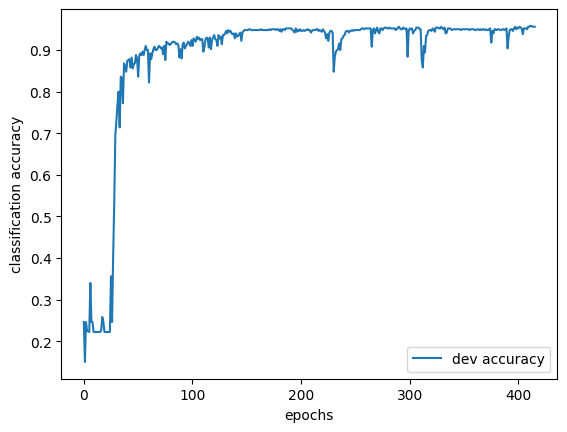

In [ ]:
# plot dev accuracy curve

plt.figure(1)
plt.plot(range(len(hyperparameter_tuning.loc[2,'dev_acc_array'])), hyperparameter_tuning.loc[2,'dev_acc_array'], label='dev accuracy')
plt.xlabel('epochs')
plt.ylabel('classification accuracy')
plt.legend()